## Softmax

In [1]:
import numpy as np

In [19]:
vector = np.array([11231, 999, 123142])

In [28]:
vector = np.array([-10, 10, 24])

In [33]:
def softmax(vec):
    vec -= np.max(vec)
    exp = np.exp(vec)
    return exp / np.sum(exp)

In [32]:
softmax(vector)

array([1.71390701e-15, 8.31528028e-07, 9.99999168e-01])

## Assignment-04 基于维基百科的词向量构建

在本章，你将使用Gensim和维基百科获得你的第一批词向量，并且感受词向量的基本过程。

![](https://www.kaggleusercontent.com/kf/1018109/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..JNNggcCCDcYEypvp7ZDwOA.cM9CuDpuCKo0K_ZkMFLAUvhfip0P6SRZ4LddwgTtgwz8pQy1dZeGVJWi6u81KSpAFNSi7YximVVJbPw8xsFySdWlqoUwvSER-LLIRfmlpsCvtDt90NaLYT2FHlwl0tfF-1MKtiFsWlGQ8LGo40hL3ccBSwMZy214kGJf9bNkW_g.kZbF5sgN5qha3zhjilfSDg/__results___files/__results___9_0.png)

## Step-01: Download Wikipedia Chinese Corpus: https://dumps.wikimedia.org/zhwiki/20190720/

第一步：使用维基百科下载中文语料库

## Step-02: Using https://github.com/attardi/wikiextractor to extract the wikipedia corpus

第二步：使用python wikipedia extractor抽取维基百科的内容

In [ ]:
# 数据抽取
bzcat /data/tusers/lixiangr/caill/NLP/data/zhwiki-20190720-pages-articles-multistream.xml.bz2 | python /data/tusers/lixiangr/caill/NLP/software/wikiextractor/WikiExtractor.py -b 3000M -o /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese - > output.txt

# 繁简转换
python -m opencc -c t2s -i /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/wiki_00 -o /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/wiki_00_Simplified

# 清洗语料
# 通过上述处理已经得到了我们想要的数据，但是在其他的一些任务中，还需要对这份数据进行简单的处理，像词向量任务
# 在这得到的数据里，还包含很多的英文，日文，德语，中文标点，乱码等一些字符，我们要把这些字符清洗掉，只留下中文字符
nohup python /data/tusers/lixiangr/caill/NLP/software/corpus_process_script/clean/clean_corpus.py --input /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/wiki_00_Simplified --output /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/wiki_00_Simplified_cleaned &

# 逐行读取文件并进行jieba分词
nohup python /data/tusers/lixiangr/caill/NLP/week4_nlp/code/wiki_jieba.py --input /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/wiki_00_Simplified_cleaned --output /data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/wiki_00_seg  &


#### 结巴分词的python脚本

In [ ]:
# /data/tusers/lixiangr/caill/NLP/week4_nlp/code/wiki_jieba.py

#! /home/lixiangr/anaconda2/envs/r-env/bin/python
#encoding-utf8
# 逐行读取文件并进行jieba分词
import jieba
import jieba.analyse
import jieba.posseg as pseg
import codecs, sys
from optparse import OptionParser

if __name__ == "__main__":

	parser = OptionParser()
	parser.add_option("--input", dest="input", default="", help="input file")
	parser.add_option("--output", dest="output", default="", help="output file")
	(options, args) = parser.parse_args()

	input = options.input
	output = options.output

	f = codecs.open(input, "r", encoding = "utf8")
	target = codecs.open(output, "w", encoding = "utf8")
	print("Open file")
	lineNum = 1
	line = f.readline()
	while line:
		print("---processing ", lineNum, "articles ---")
		seg_list = jieba.cut(line, cut_all = False)
		line_seg = " ".join(seg_list)
		target.writelines(line_seg)
		lineNum += 1
		line = f.readline()

	print("Well done!")
	f.close()
	target.close()

## Step-03: Using gensim get word vectors: 

Reference: 

+ https://radimrehurek.com/gensim/models/word2vec.html
+ https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第三步：参考Gensim的文档和Kaggle的参考文档，获得词向量。 注意，你要使用Jieba分词把维基百科的内容切分成一个一个单词，然后存进新的文件中。然后，你需要用Gensim的LineSentence这个类进行文件的读取。

在训练成词向量Model.

In [ ]:
# python /data/tusers/lixiangr/caill/NLP/week4_nlp/code/wiki_word2vec.py
# 分好词的文档即可进行word2vec词向量模型的训练了
#! /home/lixiangr/anaconda2/envs/r-env/bin/python
#encoding-utf8

import warnings
warnings.filterwarnings(action = "ignore", category = UserWarning, module = "gensim") # 忽略警告

import logging
import os.path,sys,multiprocessing
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

if __name__ == "__main__":
	program = os.path.basename(sys.argv[0])
	logger = logging.getLogger(program)
	logging.basicConfig(format = '%(asctime)s: %(levelname)s: %(message)s', level = logging.INFO)
	logger.info("running %s" % ' '.join(sys.argv))

	# inp为输入语料，outp1为输出模型，outp2为原始c版本word2vec的vector格式的模型
	fdir = '/data/tusers/lixiangr/caill/NLP/week4_nlp/output/wiki_Chinese/AA/'
	inp = fdir + '/wiki_00_seg'
	outp1 = fdir + '/wiki_00_seg_model' # 建好的模型
	outp2 = fdir + '/wiki_00_seg_vector' # 词向量

	# 训练CBOW模型
	# 参数window：表示当前词与预测词在一个句子中的最大距离是多少
	# 参数size：是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好. 推荐值为几十到几百。
	# min_count: 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
	# workers参数控制训练的并行数
	model = Word2Vec(LineSentence(inp, limit = 1000000), size = 200, window = 5, min_count = 10, workers = 24) # multiprocessing.cpu_count() # multiprocessing.cpu_count()

	# 保存模型
	model.save(outp1)
	model.wv.save_word2vec_format(outp2, binary = False)

## Step-04: Using some words to test your preformance. 

第四步，测试同义词，找几个单词。

In [1]:
# 模型训练好之后，需要去测试模型的效果
# 训练模型的参数：
# model = Word2Vec(LineSentence(inp, limit = 10000), size = 400, window = 10, min_count = 50, workers = 24)
# 推测由于用于训练的语料不足，所以得到的词向量效果不佳
import warnings
warnings.filterwarnings(action = "ignore", category = UserWarning, module = "gensim") # 忽略警告
import sys
import gensim

model = "/Users/cailingling/Documents/github/AI_NLP/wiki_00_seg_model_10000"
model = gensim.models.Word2Vec.load(model)
word = model.most_similar("是")
for t in word:
	print(t[0], t[1])

print("***********************")

word = model.most_similar("我")
for t in word:
	print(t[0], t[1])

音乐 0.9406104683876038
都 0.9380267858505249
自然 0.9350676536560059
具有 0.9286447763442993
文字 0.9269608855247498
地理学 0.9259420037269592
形式 0.9217768311500549
生物 0.9217031598091125
如 0.9198306202888489
称为 0.9125652313232422
***********************
而 0.9799896478652954
但 0.977281928062439
主张 0.9711764454841614
通过 0.9659479856491089
该 0.9655287265777588
为了 0.9653222560882568
然而 0.964486300945282
尽管 0.9585722088813782
下 0.9543555974960327
即 0.9539752006530762


/Users/cailingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if sys.path[0] == '':
/Users/cailingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


In [3]:
# 模型训练好之后，需要去测试模型的效果
# 修改了用于训练模型的参数之后，效果更优
# model = Word2Vec(LineSentence(inp, limit = 1000000), size = 200, window = 5, min_count = 10, workers = 24)
import warnings
warnings.filterwarnings(action = "ignore", category = UserWarning, module = "gensim") # 忽略警告
import sys
import gensim

model = "/Users/cailingling/Documents/github/AI_NLP/wiki_00_seg_model"
model = gensim.models.Word2Vec.load(model)
word = model.most_similar("中文")
for t in word:
	print(t[0], t[1])

print("***********************")
    
word = model.most_similar("你")
for t in word:
	print(t[0], t[1])

英文 0.7828296422958374
日文 0.6857157945632935
简体中文 0.669288694858551
译名 0.6689382195472717
简体字 0.6569117903709412
繁体中文 0.6488075256347656
输入法 0.6482561230659485
英语 0.6469682455062866
用字 0.644239068031311
日语 0.6294801235198975
***********************
我 0.8537546396255493
您 0.8305859565734863
你们 0.8150256872177124
吗 0.7639654874801636
妳 0.7379322052001953
谁 0.7270109057426453
我们 0.7127635478973389
怎么 0.7085299491882324
我会 0.7007789015769958
别人 0.7006300687789917


/Users/cailingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/Users/cailingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


## Step-05: Using visualization tools: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第五步：使用Kaggle给出的T-SEN进行词向量的可视化。

In [5]:
# 绘图    
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/cailingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


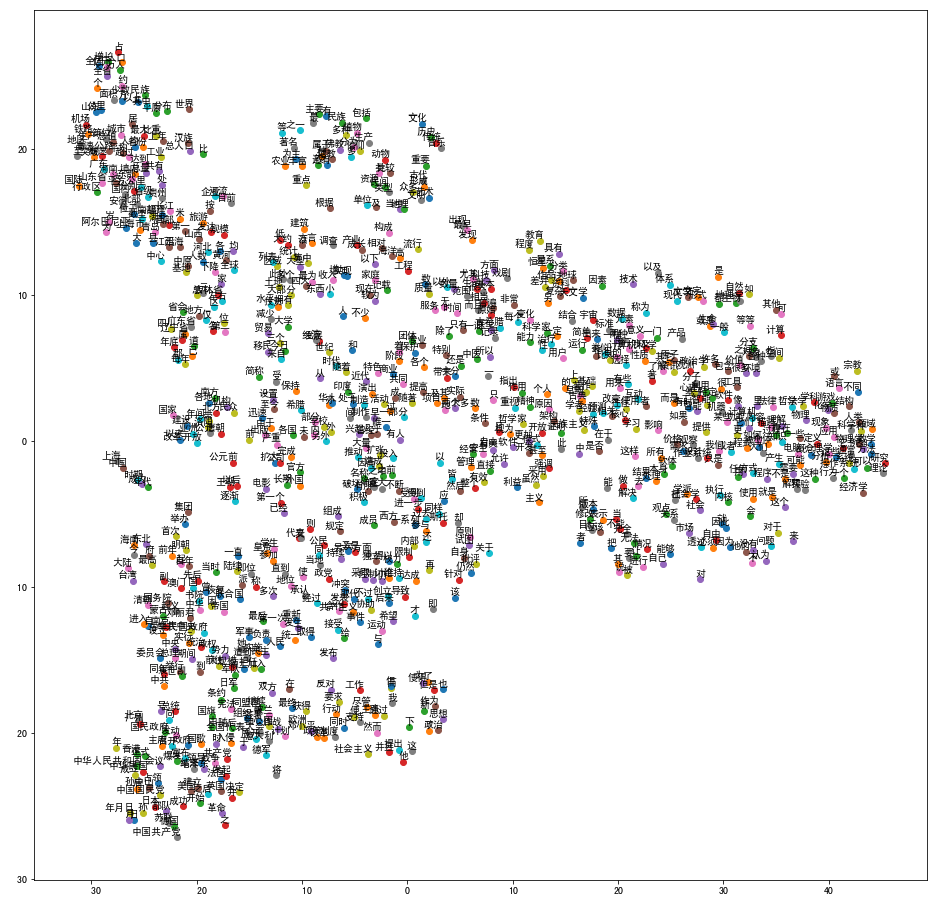

In [26]:
from sklearn.manifold import TSNE
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# model = Word2Vec(LineSentence(inp, limit = 10000), size = 400, window = 10, min_count = 50, workers = 24)
model = "/Users/cailingling/Documents/github/AI_NLP/wiki_00_seg_model_10000"
model = gensim.models.Word2Vec.load(model)
tsne_plot(model)

In [ ]:
from sklearn.manifold import TSNE
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# model = Word2Vec(LineSentence(inp, limit = 1000000), size = 200, window = 5, min_count = 10, workers = 24)
model = "/Users/cailingling/Documents/github/AI_NLP/wiki_00_seg_model"
model = gensim.models.Word2Vec.load(model)
tsne_plot(model)